In [1]:
%load_ext autoreload
%autoreload 2

from model.autoregressive import ARModel
from model import LinearModel
from filtering.colkf import ColKF
from filtering.enkf import EnKF
from utils.plotter import Plotter
from utils.compare import Comparator

import matplotlib.pyplot as plt
import numpy as np

Plotter.fig_folder = "colkf_linear_noise_noise"

In [2]:
generator = np.random.default_rng(0)

N = 40
T0 = 0
T = 15
dt = 0.01
D = 2

x0 = np.array([np.pi / 2, 0.5])
x0_cov = 0.1 * np.eye(D)

b0 = np.zeros(D)
b0_cov = 0.01 * np.eye(D)

R = lambda _: 0.05 * np.eye(D)
Q_X = lambda _: 0.05 * np.eye(D)
Q_b = lambda _: 0.000001 * np.eye(D)

b_val = -0.1
b_true = b_val * np.ones(D)

M = lambda _: np.array([[0, 1], [-2, -0.5]])
H = lambda _: np.eye(D)

A = lambda _: np.diag([1] * 2)

In [3]:
linear_model = LinearModel(
    x0,
    dt,
    M,
    H,
    Q_X,
    R,
    generator,
    solver="rk4",
    stochastic_integration=False,
    stochastic_propagation=False,
)
linear_model.discrete_forcing = lambda *_: b_true
times, states = linear_model.integrate(T0, T)
linear_model.reset_model(x0)

# Generate observations with noise
assimilation_step = 1
assimilation_times = np.linspace(1, T, int(T / assimilation_step))
observed = np.zeros((D, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / dt)
    observed[:, i] = linear_model.observe(states[:, k], add_noise=True)

In [4]:
linear_model.discrete_forcing = lambda *_: np.zeros(D)
linear_model.stochastic_integration = True

enkf = EnKF(linear_model, x0, x0_cov, N, generator=generator)
results = enkf.filter(assimilation_times, observed, cut_off_time=15)
results.true_times = times
results.true_states = states
results.figsize = "horizontal"

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:08<00:00,  1.87it/s]

Localize: False


In [5]:
H_ar = lambda _: np.zeros((0, b0.shape[0]))
ar_model = ARModel(
    A,
    H_ar,
    b0,
    dt,
    Q_b,
    generator,
    stochastic_propagation=False,
    stochastic_integration=True,
)
colkf = ColKF(ar_model, enkf, x0, x0_cov, b0, b0_cov, feedback=True)
results_col = colkf.filter(assimilation_times, observed, cut_off_time=15)
results_col.figsize = "horizontal"

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:16<00:00,  1.08s/it]

Localize: False


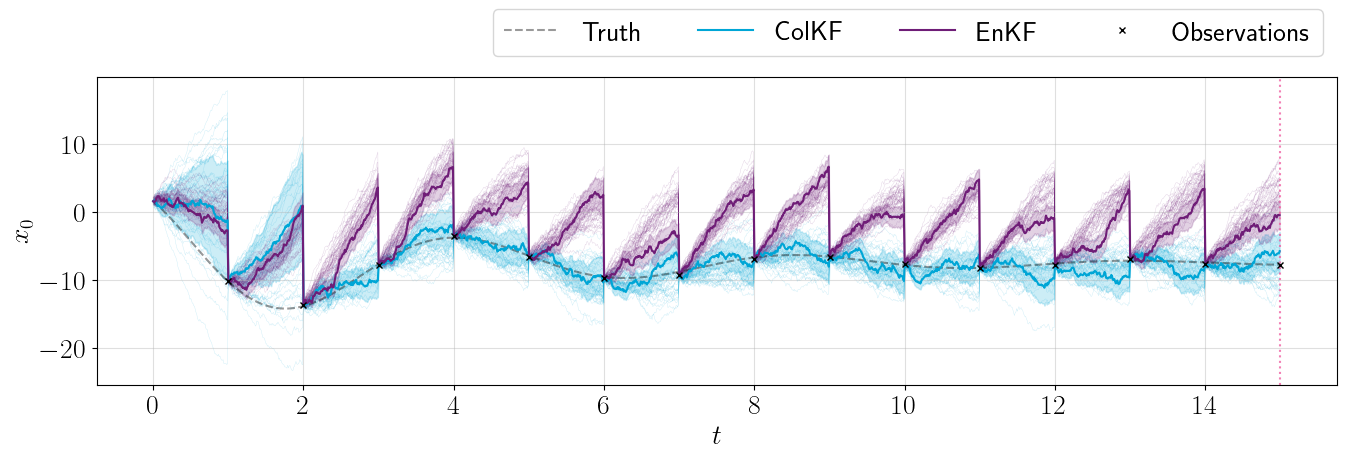

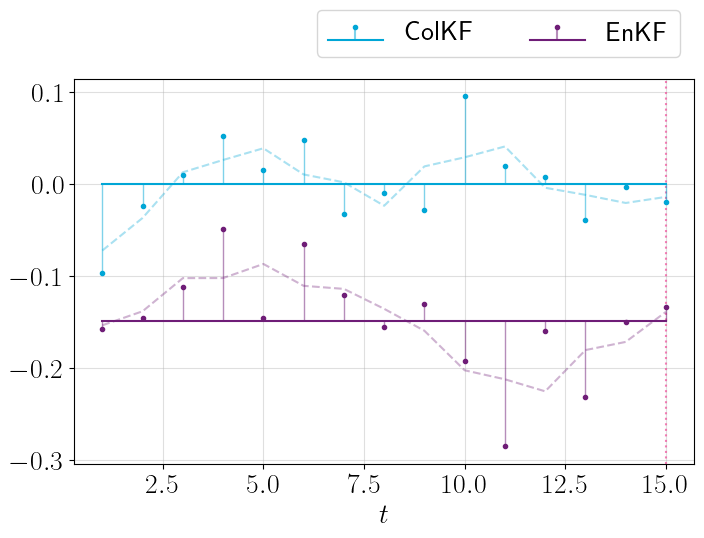

In [8]:
c = Comparator([results_col, results], ["ColKF", "EnKF"])
for i in range(1):
    c.compare_filtering(
        state_idx=i,
        plot_ensemble=True,
        plot_bands=True,
        figsize="horizontal",
        path=f"compare_x{i}",
    )
    c.compare_innovations(
        state_idx=i, figsize="standard", window=3, path=f"compare_inn_x{i}"
    )
plt.show()

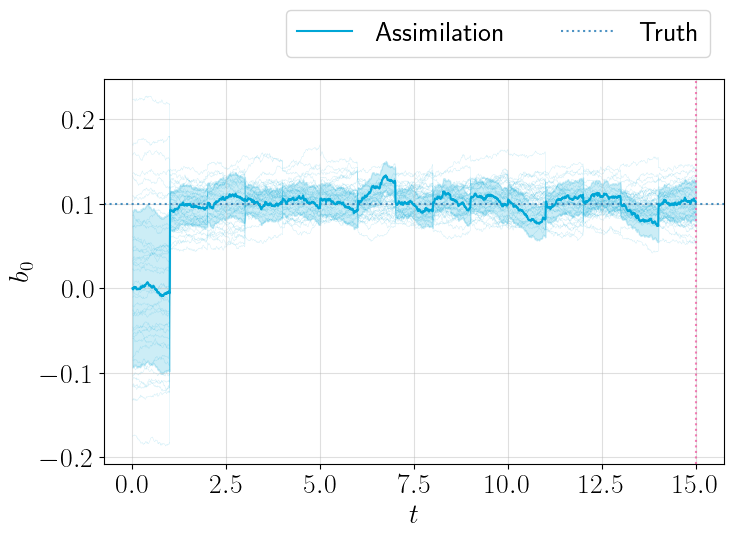

In [7]:
for i in range(2, 3):
    _, ax = Plotter.subplots(1, 1, figsize="standard")
    ax = results_col.plot_filtering(i, True, True, only_state=True, ax=ax)
    Plotter.hline(-b_val, ax=ax, path=f"bias_ar{i-2}", label="Truth")